# Лабораторная работа №5
## Выполнил: Пелагеев Даниил Иванович Б9122-01.03.02мкт
### ...

# Информация по датасету:
Это у нас датасет с пшеницой

Признаки: 
- Area — площадь семени.
- Perimeter — периметр семени.
- Compactness — компактность семени (рассчитывается как ￼).
- Length of kernel — длина ядра.
- Width of kernel — ширина ядра.
- Asymmetry coefficient — коэффициент асимметрии.
- Length of kernel groove — длина борозды ядра.

Классы: 
- Kama (Кама).
- Rosa (Роза).
- 3: Canadian (Канадская пшеница).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Загрузка данных
df = pd.read_csv('datasets/marketing_campaign.csv', sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
X = df.drop(columns=['Response'])
y = df['Response']

X.shape, y.shape

((2240, 28), (2240,))

На первом этапе загружаем данные и выделяем матрицу признаков `X`, содержащую все столбцы, кроме целевой переменной, и саму целевую переменную `y` (в данном случае это Response).

In [4]:
# Проверяем наличие пропущенных значений
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Пропущенные значения:\n", missing_values, sep="")

Пропущенные значения:
Income    24
dtype: int64


Смотрим каждый столбец на наличие пропущенных значений и выводим только те столбцы, где они присутствуют. Мы видим, что пропуски есть только в столбце `Income`.

In [5]:
# Заполняем пропуски в числовых столбцах медианным значением и в категориальных значением "missing"
numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="constant", fill_value="missing")

# Заполняем пропуски в столбце "Income" медианой
df['Income'] = numeric_imputer.fit_transform(df[['Income']])

# Просмотр данных после обработки пропусков
print(df.isnull().sum())

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64


Так как пропуски есть только в Income, мы создаем SimpleImputer для числовых данных и заполняем пропуски медианой. Это позволяет сохранить распределение значений в этом столбце. После проверяем, что пропущенные значения успешно заполнены

In [6]:
# Создаем новые признаки для улучшения анализа
df["Age"] = datetime.now().year - df["Year_Birth"]
df["Spent"] = (
        df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
        df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Определяем статус проживания
df["Living_With"] = df["Marital_Status"].replace({
    "Married": "Partner", "Together": "Partner",
    "Absurd": "Alone", "Widow": "Alone",
    "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"
})

# Признак количества детей и размера семьи
df["Children"] = df["Kidhome"] + df["Teenhome"]
df["Family_Size"] = np.where(df['Living_With'] == "Alone", 1, 2) + df["Children"]

# Признак наличия детей
df["Is_Parent"] = np.where(df["Children"] > 0, 1, 0)

# Сегментация уровня образования
df["Education"] = df["Education"].replace({
    "Basic": "Undergraduate", "2n Cycle": "Undergraduate",
    "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"
})

# Переименование некоторых столбцов для удобства
df = df.rename(columns={
    "MntWines": "Wines", "MntFruits": "Fruits",
    "MntMeatProducts": "Meat", "MntFishProducts": "Fish",
    "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"
})

# Удаление избыточных признаков
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(columns=to_drop)

# Просмотр данных после чистки
df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,1,68,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,71,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,60,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,41,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,44,422,Partner,1,3,1


На этом этапе мы создаем дополнительные признаки, которые добавляют значимую информацию для анализа. Также убираем некоторые признаки, которые для нас стали бесполезными

In [7]:
# Выделяем числовые и категориальные признаки
numeric_features = ["Income", "Age", "Spent", "Family_Size", "Children"]
categorical_features = ["Education", "Living_With"]

# Создаем преобразования для числовых признаков
numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())  # Масштабируем числовые данные
])

# Создаем преобразования для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first"))  # Кодируем категории
])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Применяем ColumnTransformer к матрице признаков
X_processed = preprocessor.fit_transform(df)
X_processed

array([[0.08483222, 0.37864078, 0.63968254, ..., 0.        , 0.        ,
        0.        ],
       [0.06709518, 0.40776699, 0.00873016, ..., 0.        , 0.        ,
        0.        ],
       [0.10509733, 0.30097087, 0.30595238, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.08309221, 0.14563107, 0.49047619, ..., 0.        , 0.        ,
        0.        ],
       [0.10153609, 0.38834951, 0.33253968, ..., 1.        , 0.        ,
        1.        ],
       [0.07690815, 0.40776699, 0.06626984, ..., 1.        , 0.        ,
        1.        ]])

Здесь мы используем ColumnTransformer для обработки числовых и категориальных признаков:

- **Числовые признаки** масштабируются с помощью `MinMaxScaler`, чтобы привести значения в диапазон от 0 до 1.
- **Категориальные признаки** кодируются с помощью `OneHotEncoder`, который превращает категориальные переменные в числовые значения, избегая мультиколлинеарности за счет исключения первой категории. `ColumnTransformer` объединяет эти преобразования и применяет их ко всей матрице признаков, что позволяет одновременно обработать числовые и категориальные данные.

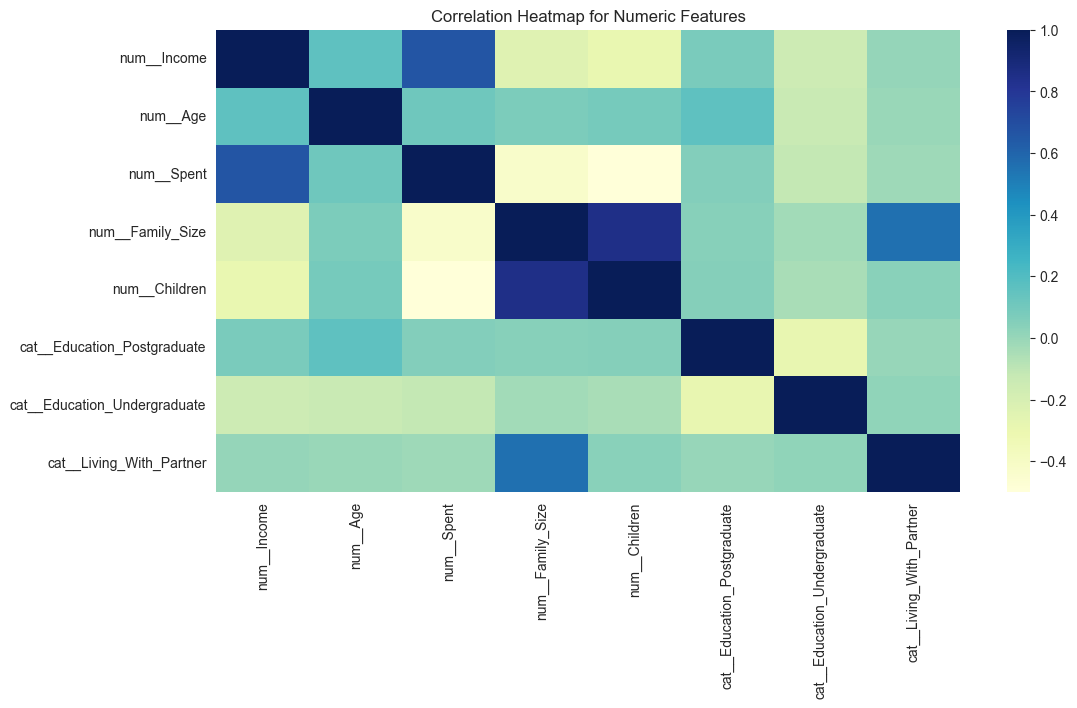

In [8]:
# Преобразуем данные обратно в dfFrame для визуализации корреляций
processed_df = pd.DataFrame(X_processed, columns=preprocessor.get_feature_names_out())

# Корреляционная матрица числовых признаков
plt.figure(figsize=(12, 6))
sns.heatmap(processed_df.corr(), cmap="YlGnBu", annot=False)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

На этом этапе мы визуализируем корреляции между числовыми признаками после предобработки данных:

1) **Преобразование в dfFrame**: Мы преобразуем `X_processed` обратно в `dfFrame`, используя имена признаков из `preprocessor`, что позволяет нам получить названия всех новых столбцов после кодирования категорий.
2) **Корреляционная матрица**: Строим тепловую карту корреляций для визуализации зависимости между числовыми признаками. Это помогает выявить потенциально скоррелированные или независимые признаки, что может быть полезным для последующего анализа.

In [9]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Проверка размеров выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1792, 8), (448, 8), (1792,), (448,))

На последнем этапе мы делим предобработанные данные на обучающую и тестовую выборки:

1) **Разделение данных**: Мы используем `train_test_split` с параметром `test_size=0.2`, чтобы выделить 80% данных для обучения модели и 20% для тестирования.
2) **Проверка размеров**: Проверяем размеры выборок (`X_train`, `X_test`, `y_train`, `y_test`), чтобы убедиться, что данные корректно разделены и готовы к дальнейшему обучению модели.